In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dataset import *
from torch.utils.data import DataLoader
from diffusion import *
from net_b import *
np.random.seed(24)

In [2]:
data_list=glob2.glob("../results_new_new/*.npy")
print("Length of dataset: ",len(data_list))
print(data_list[:10])

np.random.shuffle(data_list)

#split data into train and test 80 20
train_list=data_list[:int(0.8*len(data_list))]
test_list=data_list[int(0.8*len(data_list)):]
print("Length of train dataset: ",len(train_list))
print("Length of test dataset: ",len(test_list))
np.save("train_list_diff.npy",train_list)
np.save("test_list_diff.npy",test_list)


Length of dataset:  55280
['../results_new_new/0.5_0.275_0.2777777777777778_0.0_7_0_300.0.npy', '../results_new_new/0.35_0.5_0.4555555555555556_0.0_7_0_166.66666666666669.npy', '../results_new_new/0.425_0.275_0.32222222222222224_135.0_7_0_133.33333333333334.npy', '../results_new_new/0.275_0.425_0.3666666666666667_0.0_4_0_100.0.npy', '../results_new_new/0.35_0.2_0.4111111111111111_90.0_6_0_333.33333333333337.npy', '../results_new_new/0.425_0.2_0.14444444444444446_135.0_6_0_100.0.npy', '../results_new_new/0.2_0.425_0.4111111111111111_45.0_7_0_200.0.npy', '../results_new_new/0.2_0.275_0.23333333333333334_180.0_5_0_166.66666666666669.npy', '../results_new_new/0.275_0.5_0.4111111111111111_135.0_7_0_400.0.npy', '../results_new_new/0.5_0.275_0.14444444444444446_180.0_3_0_300.0.npy']
Length of train dataset:  44224
Length of test dataset:  11056


In [3]:
dataset_train=DataSet_hyper(train_list)
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0)
inp, tar, tar_n,maxx,minn,stack,fs=next(iter(train_loader))
print("input shape: ",inp.shape,"target shape: ",tar.shape,"target_n shape: ",tar_n.shape,"maxx shape: ",maxx.shape,"minn shape: ",minn.shape,"stack shape: ",stack.shape,"fs stack shape: ",fs.shape)

input shape:  torch.Size([1, 2, 64, 64]) target shape:  torch.Size([1, 1, 64, 64]) target_n shape:  torch.Size([1, 1, 64, 64]) maxx shape:  torch.Size([1, 1]) minn shape:  torch.Size([1, 1]) stack shape:  torch.Size([1, 2]) fs stack shape:  torch.Size([1, 4])


input shape:  torch.Size([1, 2, 64, 64]) target shape:  torch.Size([1, 1, 64, 64]) target_n shape:  torch.Size([1, 1, 64, 64]) maxx shape:  torch.Size([1, 1]) minn shape:  torch.Size([1, 1]) stack shape:  torch.Size([1, 2]) fs stack shape:  torch.Size([1, 4])


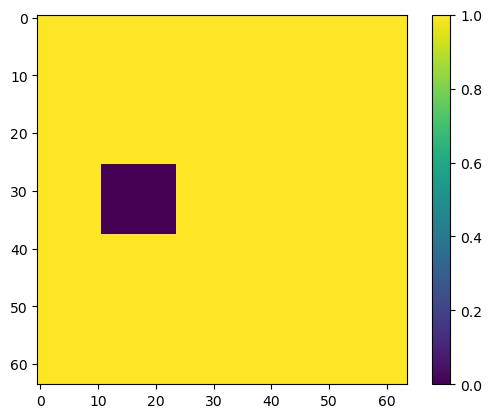

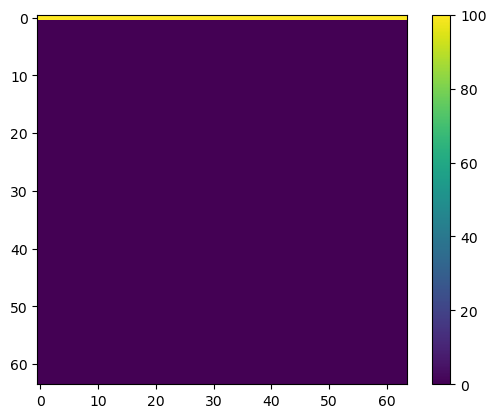

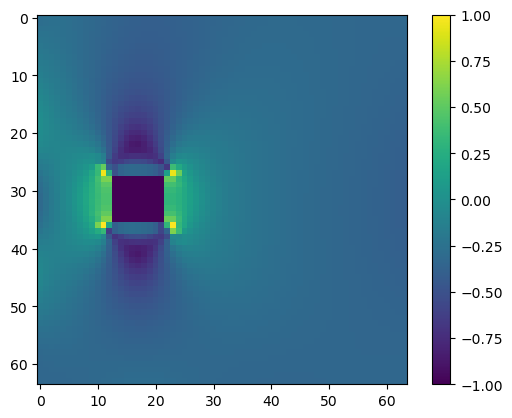

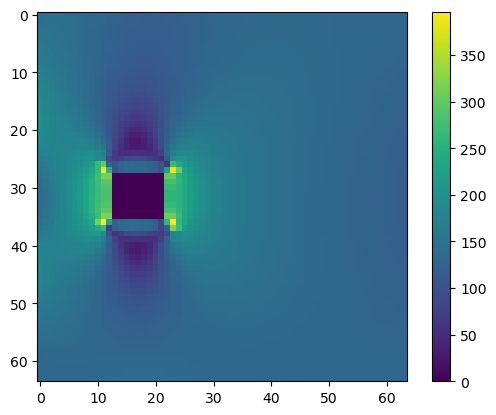

maxx:  tensor([[396.4531]], dtype=torch.float64) minn:  tensor([[0.]])
stack:  tensor([[396.4531,   0.0000]], dtype=torch.float64)
FS:  tensor([[100.,   0.,   0.,   0.]], dtype=torch.float64)


In [4]:
dataset_train=DataSet_hyper(train_list)
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0)
inp, tar, tar_n,maxx,minn,stack,fs=next(iter(train_loader))
print("input shape: ",inp.shape,"target shape: ",tar.shape,"target_n shape: ",tar_n.shape,"maxx shape: ",maxx.shape,"minn shape: ",minn.shape,"stack shape: ",stack.shape,"fs stack shape: ",fs.shape)

inns=inp.squeeze()
for i in inns:
    plt.imshow(i)
    plt.colorbar()
    plt.show()


plt.imshow(tar_n.squeeze())
plt.colorbar()
plt.show()

plt.imshow(tar.squeeze())
plt.colorbar()
plt.show()
print("maxx: ",maxx,"minn: ",minn)
print("stack: ",stack)
print("FS: ",fs)




In [5]:
from vit_min_max import *

net=VisionTransformer(embed_dim=256,hidden_dim=1024,num_heads=8,num_layers=12,num_channels=2,patch_size=4,num_patches=256).to("cuda:0")

In [6]:
inp=inp.to("cuda:0").float()
fs=fs.to("cuda:0").float()
tar_n=tar_n.to("cuda:0").float()


out=net(inp,fs)

In [7]:
diff=GaussianDiffusion(Unet(dim=64,dim_mults=(1,1,2,2,4)),image_size=64,p2_loss_weight_k=0,timesteps=500,loss_type="l1",train=True,sampling_timesteps=500).to("cuda:0")

Train Mode


In [13]:
out=diff(tar_n,inp)
print(out)

tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)


: 

In [ ]:
import glob2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from diffusion import *
from net_b import *
from Dataset_net import *
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import sys


np.random.seed(24)



data=np.load('../data/all_data_m-002.npy')
train,test=train_test_split(data,test_size=0.2,random_state=42)
# train,test=train_test_split(data,test_size=0.2,random_state=42) #original
dataset_train=DataSet_og(train)


batch_size=1000


train_loader=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
# test_loader=DataLoader(dataset_test,batch_size=batch_size,shuffle=True,num_workers=12,pin_memory=True)

epochs=1000

diff=GaussianDiffusion(Unet(dim=64,dim_mults=(1,1,2,2,4)),image_size=32,p2_loss_weight_k=0,timesteps=500,loss_type="l1").to("cuda:3")

diff=nn.DataParallel(diff,device_ids=[3,2])

optimizer=optim.Adam(diff.parameters(),lr=1e-3)#1e-3
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=25,factor=0.75,threshold=0.1, verbose=True,min_lr=1e-8)

name="diff_64_11224_T500_seed_42_og_run1"
print("Number of training samples: ",len(train))

epoch_done=0

tb=SummaryWriter("./runs/"+name)
# loaded=torch.load("./models/diff_64_11224_T500_seed_31_og_run1.pth")
# # from collections import OrderedDict
# # new_state_dict = OrderedDict()
# # for k, v in loaded["model_state_dict"].items():
# #     name_k = k[7:] # remove `module.`
# #     new_state_dict[name_k] = v


# diff.load_state_dict(loaded["model_state_dict"],strict=False)
# optimizer.load_state_dict(loaded["optimizer_state_dict"])
# scheduler.load_state_dict(loaded["scheduler_state_dict"])
# epoch_done=loaded["epoch"]#331
# loss=loaded["loss"]#0.0021 -- 0.0030
# print("loaded epoch, loss, lr",epoch_done,loss.item())#,optimizer.param_groups[0]["lr"])
 
print("Training:"+name)
diff.train()

for epoch in (range(epoch_done,epochs)):
    
    st=time.time()
    print("starting epoch: ",epoch)
    l_b=[]
    l_sc=[]

    for inputs,targets,target_n,mean,std,stack,fs in tqdm(train_loader):
        inputs=inputs.to("cuda:3").float()
        targets=targets.to("cuda:3").float()
        target_n=target_n.to("cuda:3").float()
        mean=mean.to("cuda:3")
        std=std.to("cuda:3")
        stack=stack.to("cuda:3")

        optimizer.zero_grad()

        loss=diff(target_n,inputs)

        loss=loss.mean()
        # print(loss.item())

        loss.backward()
        optimizer.step()
        l_b.append(loss.item())

        
    scheduler.step(np.array(l_b).mean())
    print("Epoch: ",epoch,"Loss: ",np.array(l_b).mean(),"Time: ",time.time()-st)
    tb.add_scalar("Loss",loss.item(),epoch)


    # torch.save({'epoch': epoch,"model_state_dict":diff.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': loss,"scheduler_state_dict":scheduler.state_dict()}, "./models/"+name+".pth")



